# Declaring necessary imports

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Defining SOM

In [2]:
class SOM():
    def __init__(self, m, n, dim, num_iterations=1, learning_rate=0.5, sigma=None):
        self._m = m
        self._n = n
        self._neighborhood = []
        self._topography = []
        self._num_iterations = int(num_iterations)
        self._learned = False
        self.dim = dim
        self.d = 0
        
        if sigma is None:
            sigma = max(m, n)/2.0 # Constant radius
        else:
            sigma = float(sigma)
            
        self.learning_rate = learning_rate
        self.learning_rate_0 = learning_rate
        self.sigma = sigma
        self.sigma_0 = sigma
        
        print('Network created with dimensions',m,n)
        
        #Weight Matrix and the topography of neurons
        self._W = tf.random.normal([m*n, dim], seed=0)
        
        #Topography nos define un array de (30x30) x 2 (900 x 2) donde cada fila representa las coordenadas en el
        #mapa de esa unidad. Por ejemplo la unidad 5 de la lista esta en las coordenadas [0,5], la 200 en la [6, 20]
        #y la ultima es la [30, 30]
        self._topography = np.array(list(self._neuron_location(m, n)))
        
    # Funcion para generar las posiciones en la malla para un array de unidades
    def _neuron_location(self, m, n):
        for i in range(m):
            for j in range(n):
                yield np.array([i,j])
                
    def training(self, x, i):
        m = self._m
        n = self._n
        
        #1. Obtencion de las distancias y seleccion de BMU(idx)
        d = tf.sqrt(tf.reduce_sum(tf.pow(self._W - tf.stack([x for i in range(m*n)]), 2), 1))
        self.BMU_idx = tf.argmin(d, 0)
        self.d = d
        
        #2 Obtener BMU para el idx
        self.BMU_loc = self._topography[self.BMU_idx]
        
        #3. Actualizar sigma y learning rate
        lambda_coeff = self._num_iterations/self.sigma_0
        learning_rate = self.learning_rate_0*np.exp(-1/lambda_coeff)
        sigma = self.sigma_0*np.exp(-1/lambda_coeff)
        
        #4. Calcular b_ij
        beta_ij = np.exp((-d**2)/(2*sigma**2))
        
        #5. Eligir vecinos
        neighbs = [self._check_point(p[0], p[1], self.BMU_loc[0], self.BMU_loc[1], sigma) for p in self._topography]
        
        #6. Coeficiente para actualizar pesos
        weight_multiplier = tf.math.multiply(beta_ij, neighbs)
        weight_multiplier = tf.math.multiply(learning_rate, weight_multiplier)
        
        #7. Valor para actualizar pesos
        delta_W = tf.subtract(tf.stack([x for i in range(m*n)]), self._W)
        weight_multiplier = tf.stack([weight_multiplier for i in range(n_dim)], axis=1)
        update_value = tf.multiply(weight_multiplier, weight_multiplier)
        update_value = tf.multiply(weight_multiplier, delta_W)
        
        #8. Actualización pesos
        new_W = self._W + update_value
        self._W = new_W
        
    #Comprobar si un punto esta dentro del radio alrededor del otro
    def _check_point(self, x, y, center_x, center_y, radius):
        check = (x - center_x)**2 + (y - center_y)**2 < radius**2
        if check == True:
            return 1
        else:
            return 0
        
    def fit(self, X):
        # Preparar datos de entrada
        np.random.shuffle(X)
        X = tf.cast(X, tf.float32)
        
        #Iteraciones
        for i in range(self._num_iterations):
            for x in X:
                self.training(x, i)
                
        #Guardar información
        self._Wts = list(self._W)
        self._locations = list(self._topography)
        self._learned = True
        
    def winner(self, X):
        if not self._learned:
            raise ValueError('SOM not trained yet')
            
        return self.BMU_loc.numpy()
    
    def map_vects(self, X):
        if not self._learned:
            raise ValueError('SOM not trained yet')
            
        to_return = []
        for vect in X:
            min_index = min([i for i in range(len(self._Wts))], key=lambda x: np.linalg.norm(vect - self._Wts[x]))
            to_return.append(self._locations[min_index])
            
        return to_return
    
    def distance_map(self):
        if not self._learned:
            raise ValueError('SOM not trained yet')
        
        mapping = tf.reshape(self.d, shape=(self._m, self._n)).numpy()
        return mapping

# I. Preparar los datos
## Cargar los datos

In [3]:
dataset = pd.read_csv('Data_Sources/Credit_Card_Applications.csv')
X = dataset.copy().drop(columns=['CustomerID', 'Class']).values
y = dataset.iloc[:, -1].values # Variable que dice si la application del customer fue aprobada o no

## Feature Scaling

In [4]:
sc = MinMaxScaler(feature_range = (0,1)) # Para que todos los valores esten entre 0 y 1
X = sc.fit_transform(X)

# II. Entrenar el modelo
## Hyperparametros

In [5]:
n_dim = np.shape(X)[1]
grid_size = (10,10)
sigma = 10
num_iterations = 50
learning_rate = 0.5

## Fit & Train

In [6]:
som = SOM(
    grid_size[0],
    grid_size[1],
    dim=n_dim,
    num_iterations=num_iterations,
    learning_rate=learning_rate,
    sigma=sigma)
som.fit(X)

Network created with dimensions 10 10


## Malla con el MID de cada unidad

In [7]:
distance_matrix = som.distance_map().T

# III. Visualización de resultados

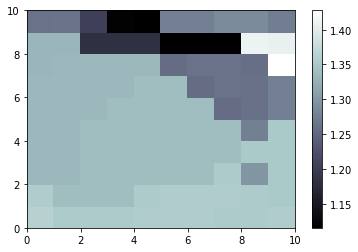

In [8]:
from pylab import bone, pcolor, colorbar
bone() #Inicializo la ventana de visualización
pcolor(distance_matrix) # Pinto el MID de los nodos
colorbar() # Para tener la leyenda de colores. Vere que los MID van de 0 a 1, porque estan escalados

In [16]:
max_value = np.amax(distance_matrix)
min_value = np.amin(distance_matrix)
list_mid = list(np.reshape(distance_matrix, (grid_size[0]*grid_size[1],)))
list_mid.sort()
list_mid = [j for j in list_mid if j > 1.38]
list_idx = [np.where(distance_matrix==j) for j in list_mid]
list_idx = [[idx_max[0][0], idx_max[1][0]] for idx_max in list_idx]
mappings = som.map_vects(X)

# IV. Detectar anomalías

In [17]:
df_users = pd.DataFrame()

for i, x in enumerate(X): #i son los valores de los indices, y x son los distintos vectores de customers en 
#cada iteración, y recorro el dataset X con enumerate(X)
    w = mappings[i] #BMU para ese registro
    #Si el BMU coincide con las unidades de los outliers, lo identificamos como fraudelento
    is_fraud = False
    # Fraude si la variable tiene de BMU una de la lista de fraudulentas
    if [w[0], w[1]] in list_idx:
        is_fraud = True
    #Guardar resultados
    df_users = df_users.append(pd.DataFrame({
        'user': [dataset.iloc[i]['CustomerID']],
        'mapping':[w],
        'is_fraud':[is_fraud],
        'credit_approval':[dataset.iloc[i]['Class']]
    }))
df_users[df_users['is_fraud'] == True].head()

,user,mapping,is_fraud,credit_approval
0,15726466.0,"[8, 8]",True,0.0
0,15692408.0,"[8, 8]",True,1.0
0,15683168.0,"[8, 8]",True,1.0
0,15813718.0,"[7, 9]",True,0.0
0,15815271.0,"[7, 9]",True,0.0
